## This is a simple example to show how to use timeseriesprocessing package.

## We'll use only weather information to predict energy data from tepco.

In [1]:
# import library
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import copy
from timeseriesprocessing.regression import utilities
from timeseriesprocessing.regression import constants

%matplotlib inline

# global definitions
COLUMNS_DICT_FOR_PLOT_INDEPENDENT_VARIABLES = {"temperature": "temperature", "rain_amount": "rain amount"}
COLORS_DICT_FOR_PLOT_INDEPENDENT_VARIABLES = {"temperature": "black", "rain_amount": "maroon"}
COLUMNS_DICT_FOR_PLOT_TARGET_VARIABLES = {"energy": "Energy(Million kW)"}
COLORS_DICT_FOR_PLOT_TARGET_VARIABLES = {"energy": "crimson"}
COLUMNS_ARRAY_FOR_INDEPENDENT_VARIABLES = np.array(["rain_amount", "temperature"
                                                    #,"weekend"
                                                    , "time_zone"
                                                   ])
COLUMNS_ARRAY_FOR_TARGET_VARIABLES = np.array(["energy"])

### Read Energy data from tepco
### Read Weather data downloaded from JMA(Japan Meteorological Agency)

In [2]:
# Read Energy data from tepco
energy_data_url="http://www.tepco.co.jp/forecast/html/images/juyo-2017.csv"
energy_data_df = pd.read_csv(energy_data_url, skiprows=[0, 1], encoding="shift-jis")
energy_data_df.columns = ["DATE", "TIME", "energy"]
energy_data_df["time"] = energy_data_df["DATE"] + " " + energy_data_df["TIME"] + ":00"

# Read Weather data downloaded from JMA(Japan Meteorological Agency)
weather_data_df = pd.read_csv("../sample_data/weather_201709.csv",
                              skiprows=[0, 1, 2, 4],# dont skip 3rd row as it's the header
                              encoding="SHIFT-JIS")

# extract time, rain_amount, temperature data 
weather_data_df = weather_data_df.iloc[:, [0, 1, 7]]
weather_data_df.columns = ["time", "rain_amount", "temperature"]

time_series = weather_data_df["time"]

weekend_array = copy.deepcopy(time_series.values)
time_array = copy.deepcopy(time_series.values)

# add weekend as a new feature
for i in range(0, weekend_array.shape[0]):
    weekend_array[i] = float(
        datetime.strptime(weekend_array[i], '%Y/%m/%d %H:%M:%S').weekday())
    if weekend_array[i] == 5 or weekend_array[i] == 6:
        weekend_array[i] = 1
    else:
        weekend_array[i] = 0

# add day/night as a new feature
for i in range(0, time_array.shape[0]):
    time_array[i] = float(datetime.strptime(time_array[i], '%Y/%m/%d %H:%M:%S').hour)
    if time_array[i] > 6.0:
        time_array[i] = 0.0
    else:
        time_array[i] = 1.0

#weather_data_df["weekend"] = weekend_array
weather_data_df["time_zone"] = time_array

### Prepare Training and Test Data Set

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


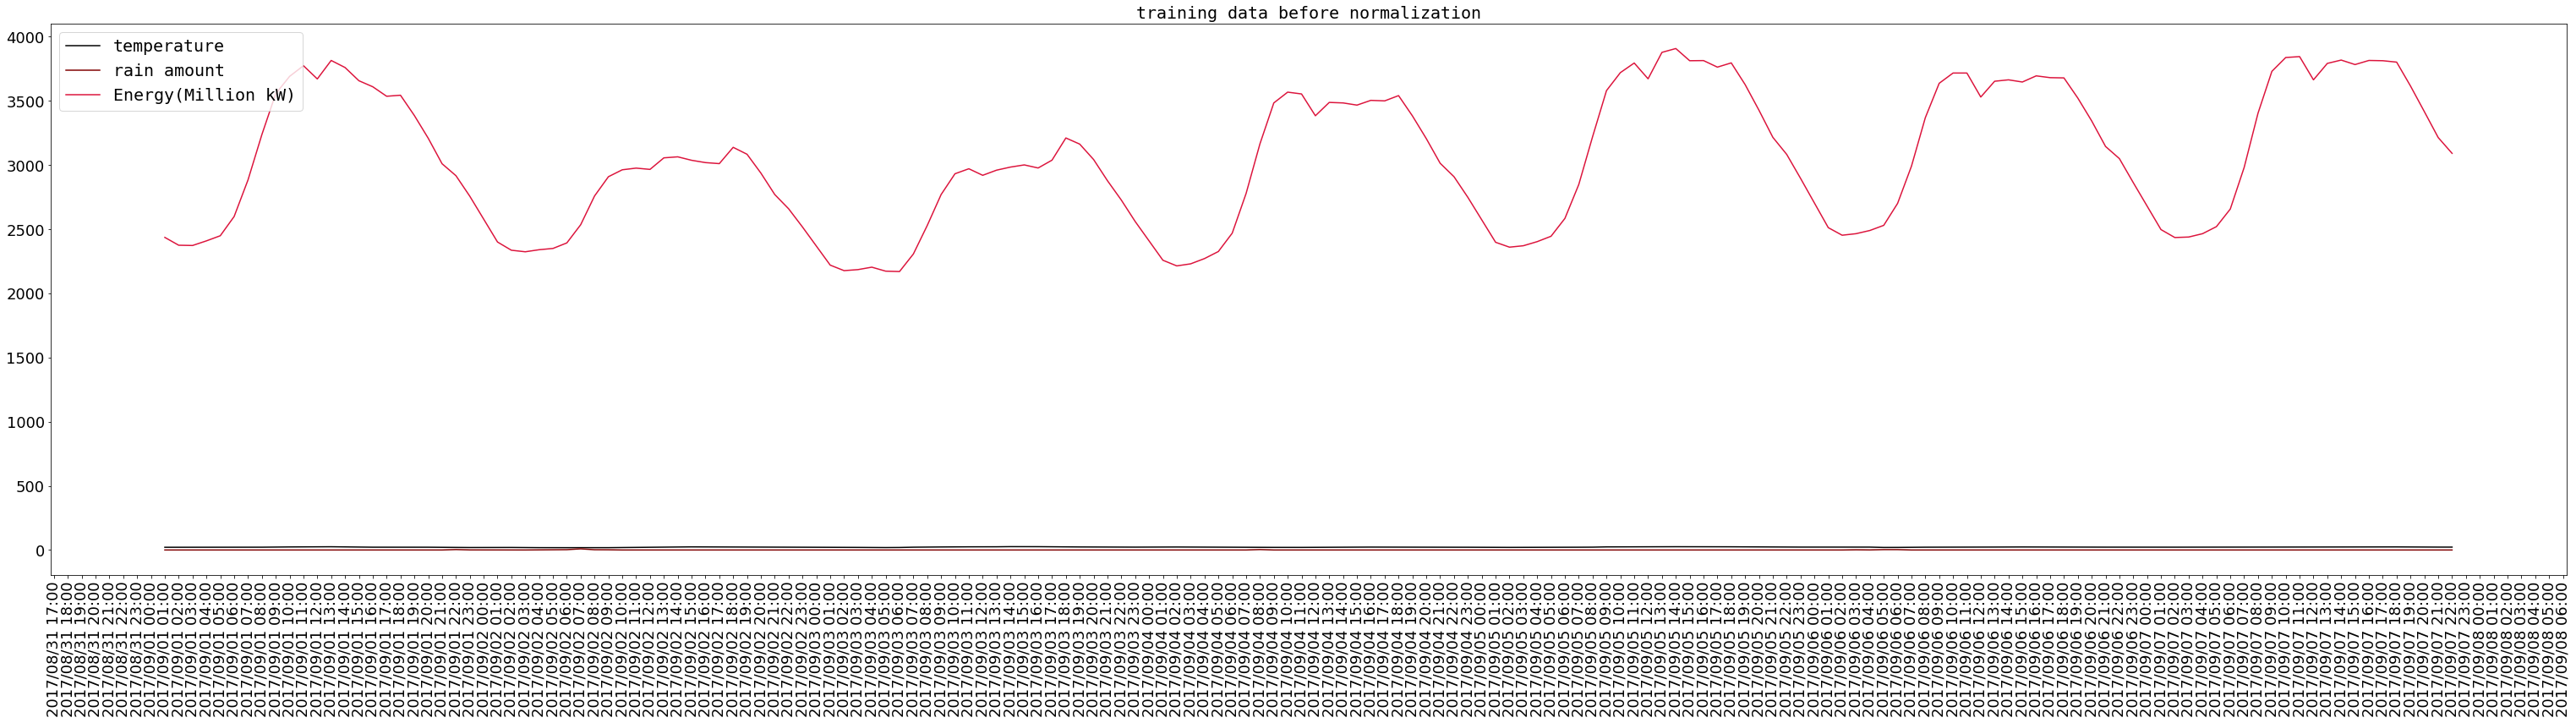

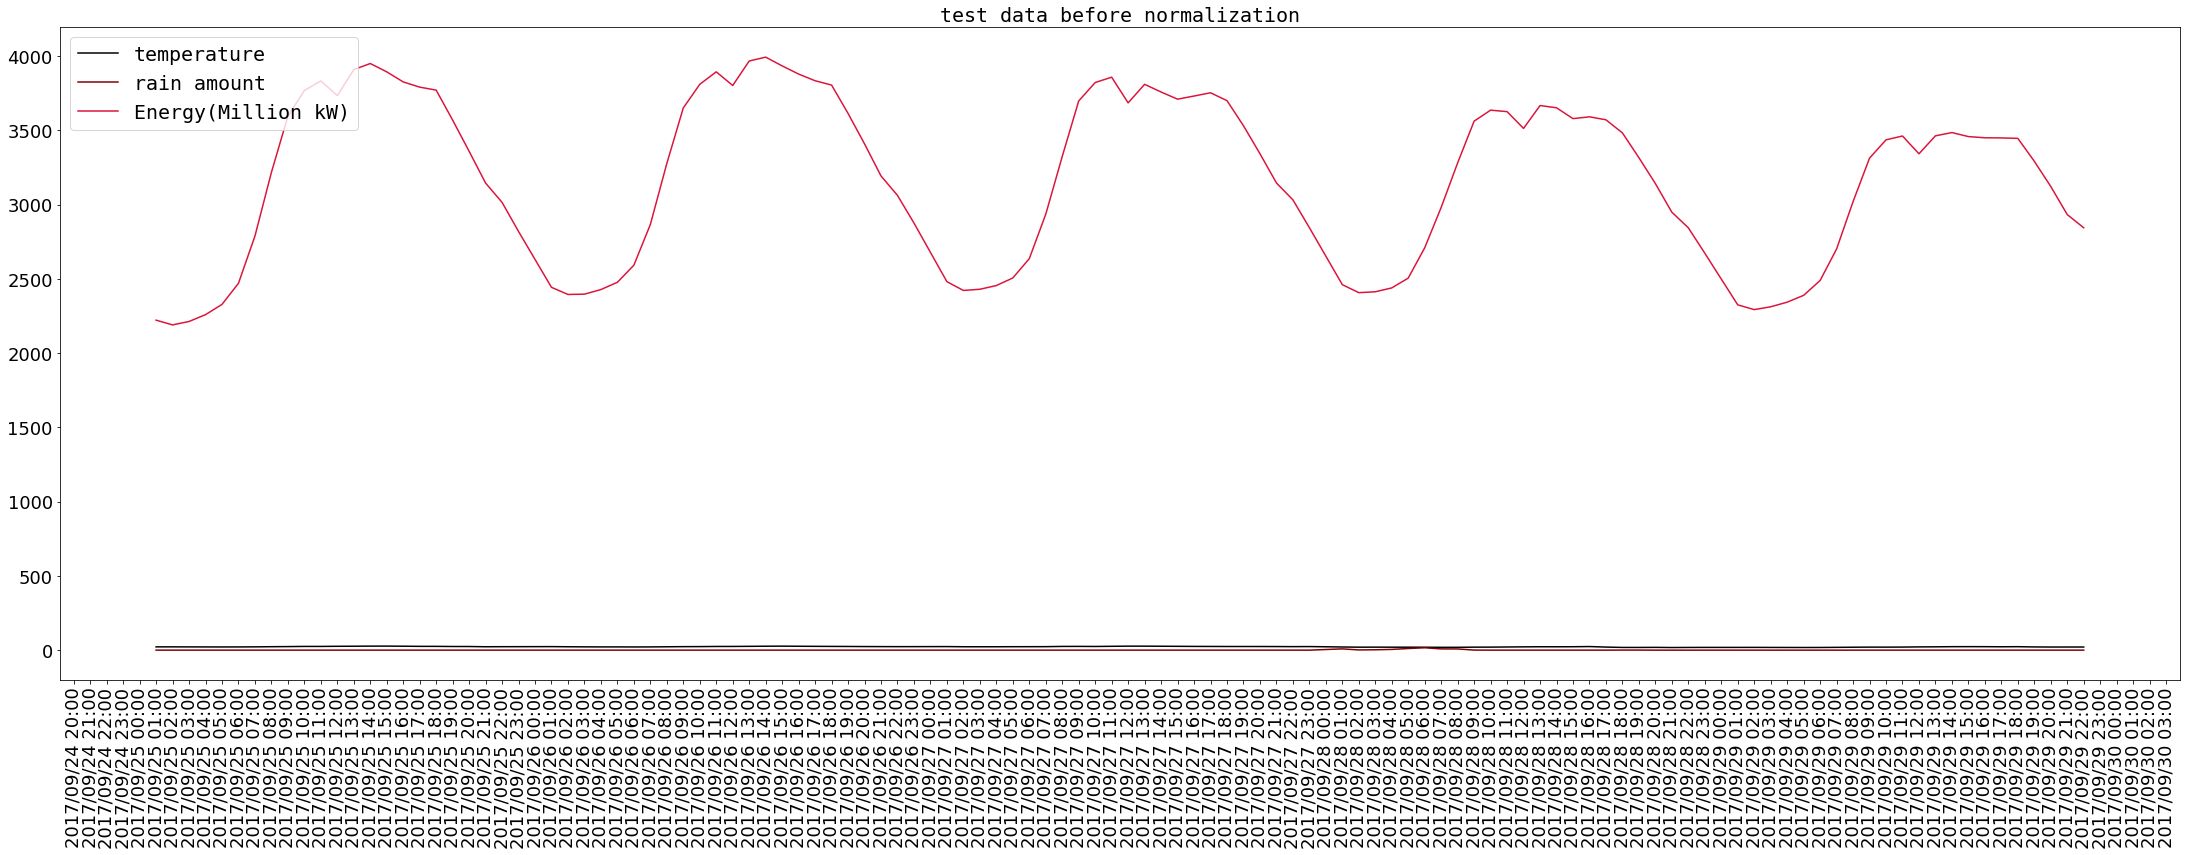

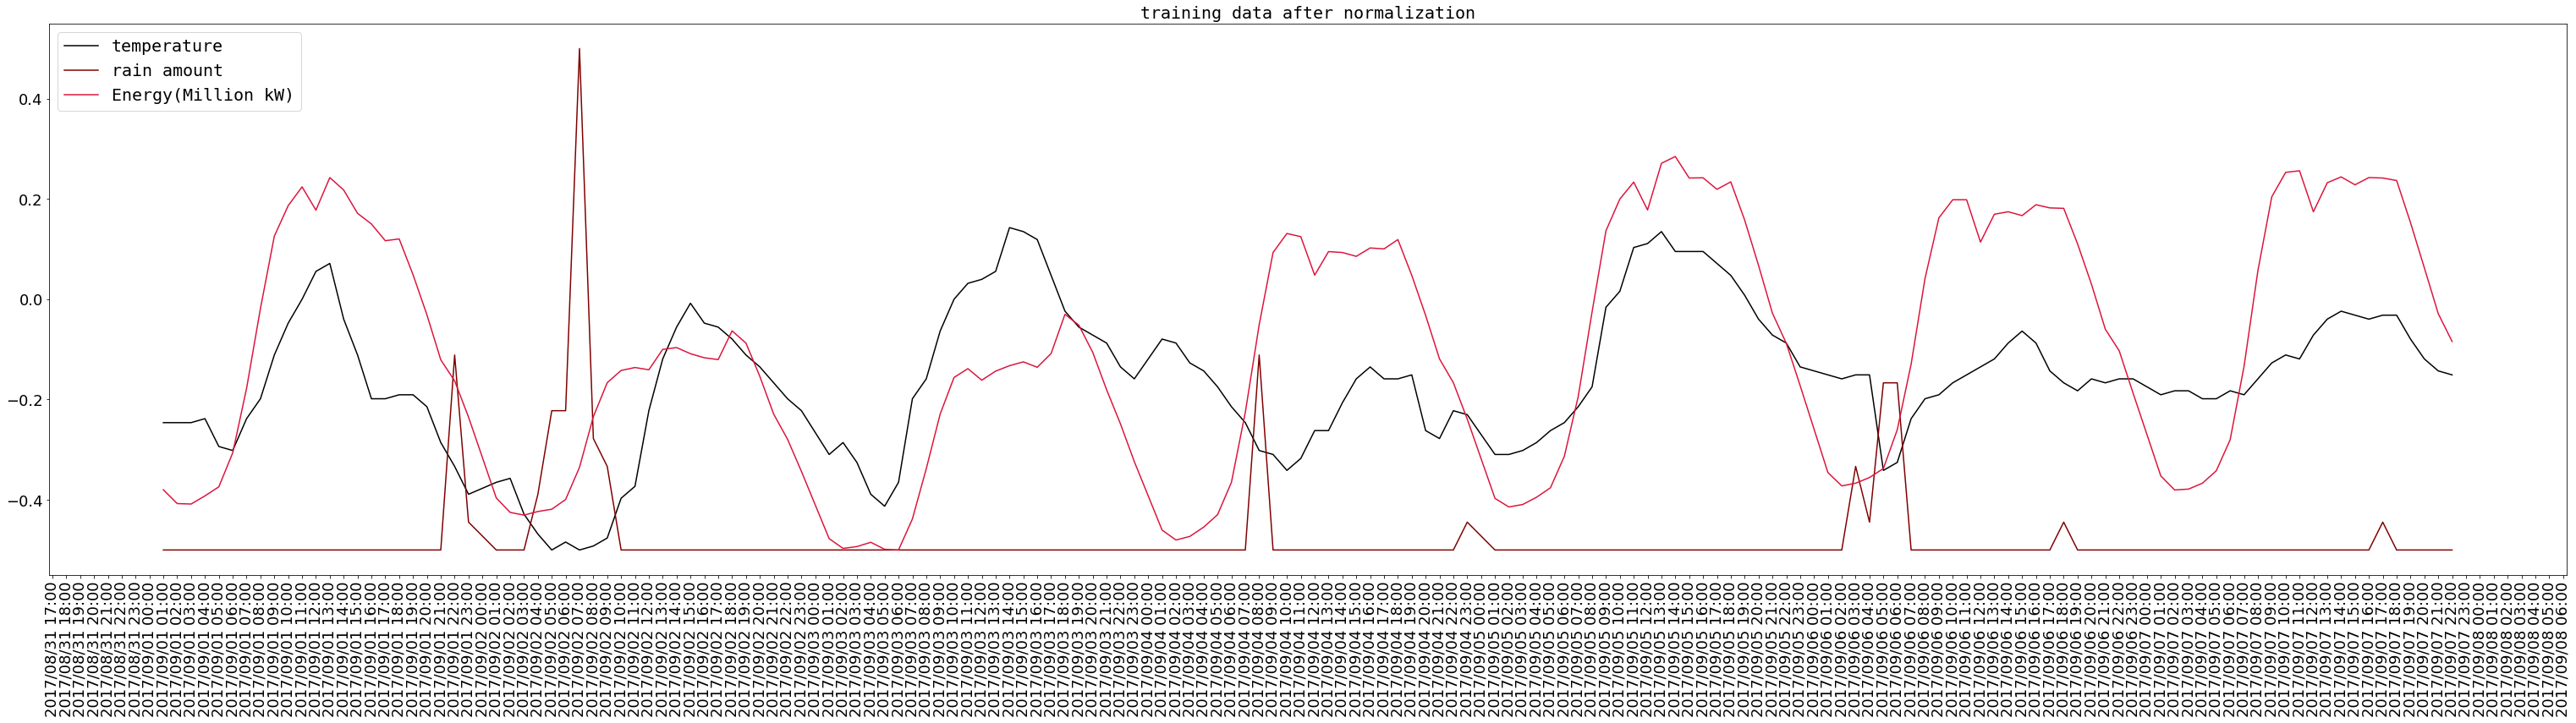

In [3]:
# merge Energy and Weather data as a data set
data_df = pd.merge(weather_data_df, energy_data_df).reset_index(drop=True)

# split the data set as training(80%) and test(20%)
from sklearn.model_selection import train_test_split
x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(data_df.loc[:,["time", "temperature", "rain_amount", "weekend", "time_zone"]], 
                                                                data_df.loc[:,COLUMNS_ARRAY_FOR_TARGET_VARIABLES], 
                                                                test_size=0.2, shuffle=False)
x_test_df = x_test_df.reset_index(drop=True)
y_test_df = y_test_df.reset_index(drop=True)

time_train_df = x_train_df.loc[:, ["time"]]
x_train_df = x_train_df.loc[:, COLUMNS_ARRAY_FOR_INDEPENDENT_VARIABLES]
time_test_df = x_test_df.loc[:, ["time"]]
x_test_df = x_test_df.loc[:, COLUMNS_ARRAY_FOR_INDEPENDENT_VARIABLES]

# plot training data
utilities.plot_data(time_train_df, 
                    x_train_df, 
                    COLUMNS_DICT_FOR_PLOT_INDEPENDENT_VARIABLES, 
                    COLORS_DICT_FOR_PLOT_INDEPENDENT_VARIABLES, 
                    y_train_df, 
                    COLUMNS_DICT_FOR_PLOT_TARGET_VARIABLES, 
                    COLORS_DICT_FOR_PLOT_TARGET_VARIABLES, 
                    start_datetime="2017/09/01 01:00", end_datetime="2017/09/07 23:00", title="training data before normalization")

# plot test data
utilities.plot_data(time_test_df, 
                    x_test_df, 
                    COLUMNS_DICT_FOR_PLOT_INDEPENDENT_VARIABLES, 
                    COLORS_DICT_FOR_PLOT_INDEPENDENT_VARIABLES, 
                    y_test_df, 
                    COLUMNS_DICT_FOR_PLOT_TARGET_VARIABLES, 
                    COLORS_DICT_FOR_PLOT_TARGET_VARIABLES, 
                    start_datetime="2017/09/25 01:00", end_datetime="2017/09/29 23:00", title="test data before normalization")


# normalize independent variables
x_train_df = utilities.range_scale_data(x_train_df)
x_test_df = utilities.range_scale_data(x_test_df)

# plot normalized training data
utilities.plot_data(time_train_df, 
                    x_train_df, 
                    COLUMNS_DICT_FOR_PLOT_INDEPENDENT_VARIABLES, 
                    COLORS_DICT_FOR_PLOT_INDEPENDENT_VARIABLES, 
                    utilities.range_scale_data(y_train_df), 
                    COLUMNS_DICT_FOR_PLOT_TARGET_VARIABLES, 
                    COLORS_DICT_FOR_PLOT_TARGET_VARIABLES, 
                    start_datetime="2017/09/01 01:00", end_datetime="2017/09/07 23:00", title="training data after normalization")

We can see here that there exists a strong correlation between Energy and Temperature.
Rain amount actually makes nonsense here, but we' still use it as a feature. we'll show later that the weight would be almost 0.
We also add weekend/weekday, day/night as tow new features.

So we'll have four features to build our models.

features:
- Temperature  
- Rain Amount  
- weekend/weekday  
- day/night  
          
Target for prediction: 
- Energy

### Train Models Using Lasso and Random Forest

Lasso


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:1103: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


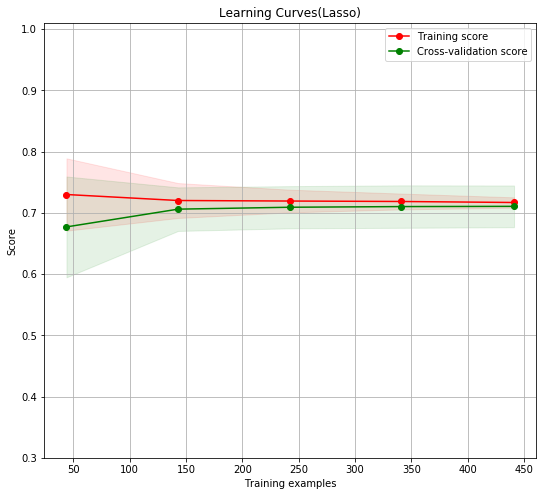

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


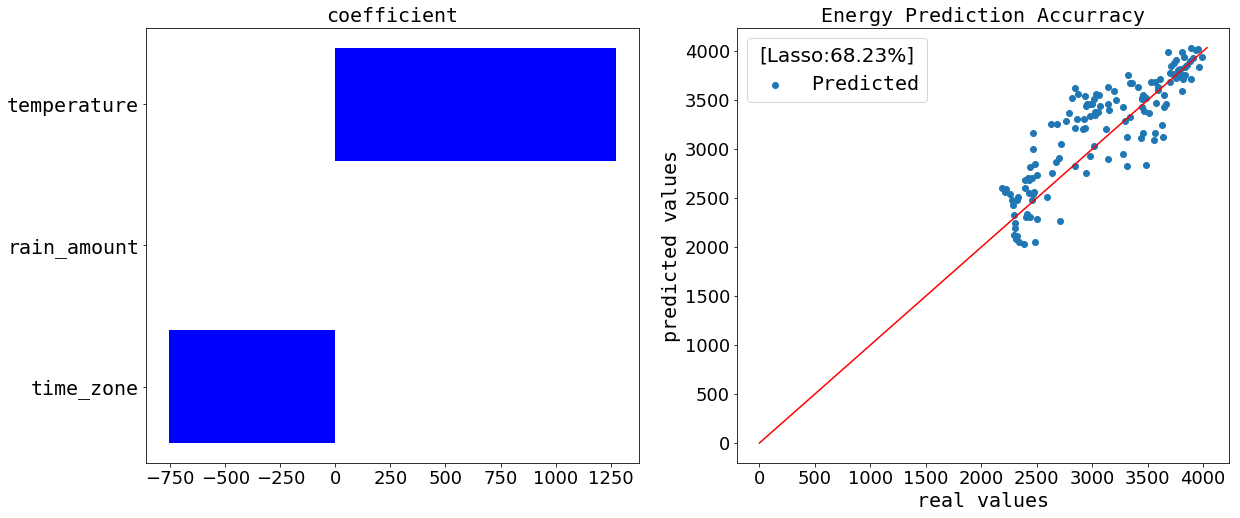

MAE of Lasso:243.98419


Random Forest


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:1103: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


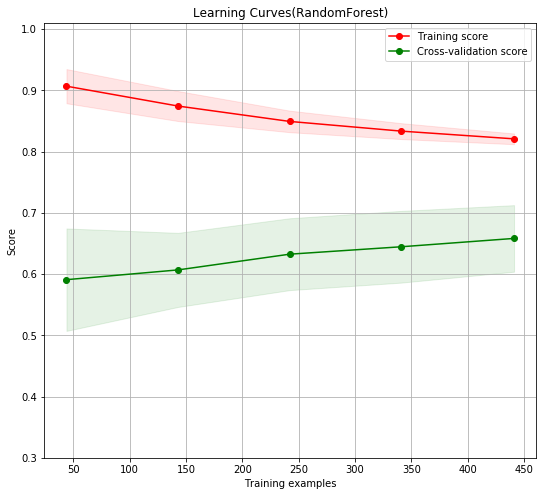

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


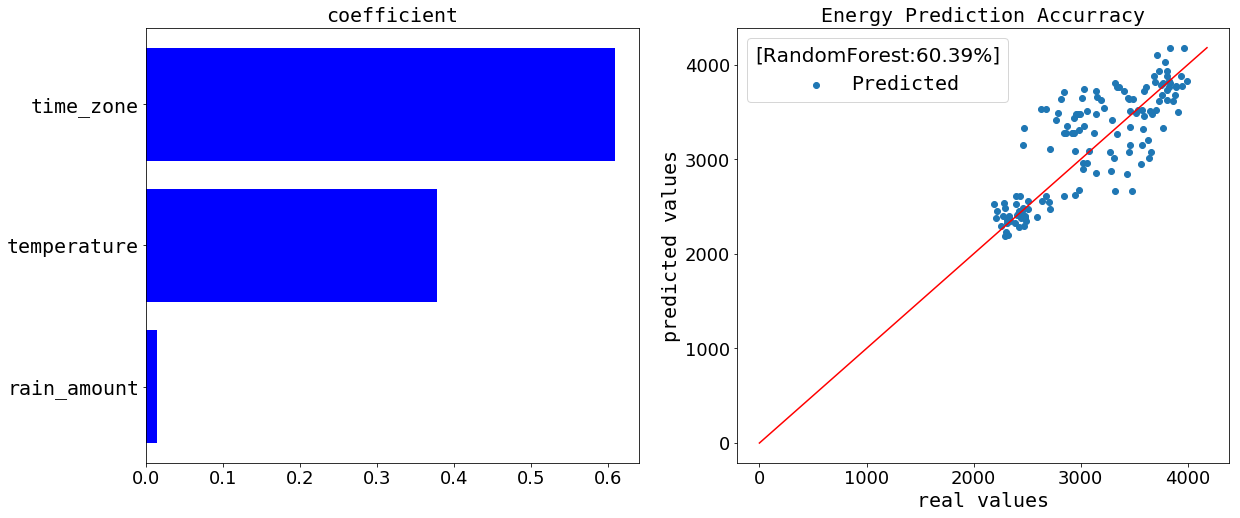

MAE of Random Forest:261.16707


In [4]:
print("Lasso")
clf_lasso = utilities.build_model(constants.MODEL_NAME_LASSO, x_train_df.as_matrix(), y_train_df.as_matrix())
predictions_lasso, accuracy_lasso, mae_lasso = utilities.evaluate_model(constants.MODEL_NAME_LASSO, clf_lasso, 
                                                                        x_test_df.as_matrix(), 
                                                                        y_test_df.as_matrix(), 
                                                                        COLUMNS_ARRAY_FOR_INDEPENDENT_VARIABLES, 
                                                                        "Energy Prediction")
print("MAE of Lasso:"+ str(float("{0:.5f}".format(mae_lasso))))
print("\n")
print("Random Forest")
clf_randomForest = utilities.build_model(constants.MODEL_NAME_RANDOM_FOREST, x_train_df.as_matrix(), y_train_df.as_matrix())
predictions_rf, accuracy_rf, mae_rf = utilities.evaluate_model(constants.MODEL_NAME_RANDOM_FOREST, 
                                                               clf_randomForest, 
                                                               x_test_df.as_matrix(), 
                                                               y_test_df.as_matrix(), 
                                                               COLUMNS_ARRAY_FOR_INDEPENDENT_VARIABLES, 
                                                               "Energy Prediction")
print("MAE of Random Forest:"+ str(float("{0:.5f}".format(mae_rf))))
# The following method is supported but not included in this example.
# use utilities.export_predictions_to_csv to save your predictions to csv files.

So we can see here that time_zone(day/night) and temperature have strong relations with Energy, while rain amount is not a good feature to use.

The metric used to calculate the accuracy here is R^2 (coefficient of determination).

Note: MAE here shows us larger values over 200, but remenber that MAE(also RMSE and so on) has the same unit as our predictions. As the unit of predictions here is kW, we need to change the unit to W so that MAE values are between 0.21~0.25.

Not a bad result, but still need to refine.

### Plot Real and Predicted Values of Energy Data

/opt/pythonlibs/mnt/timeseriesprocessing/regression/utilities.py:407: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  [datetime.strptime(t, "%Y/%m/%d %H:%M:%S") for t in time_df.as_matrix().transpose()[0]])


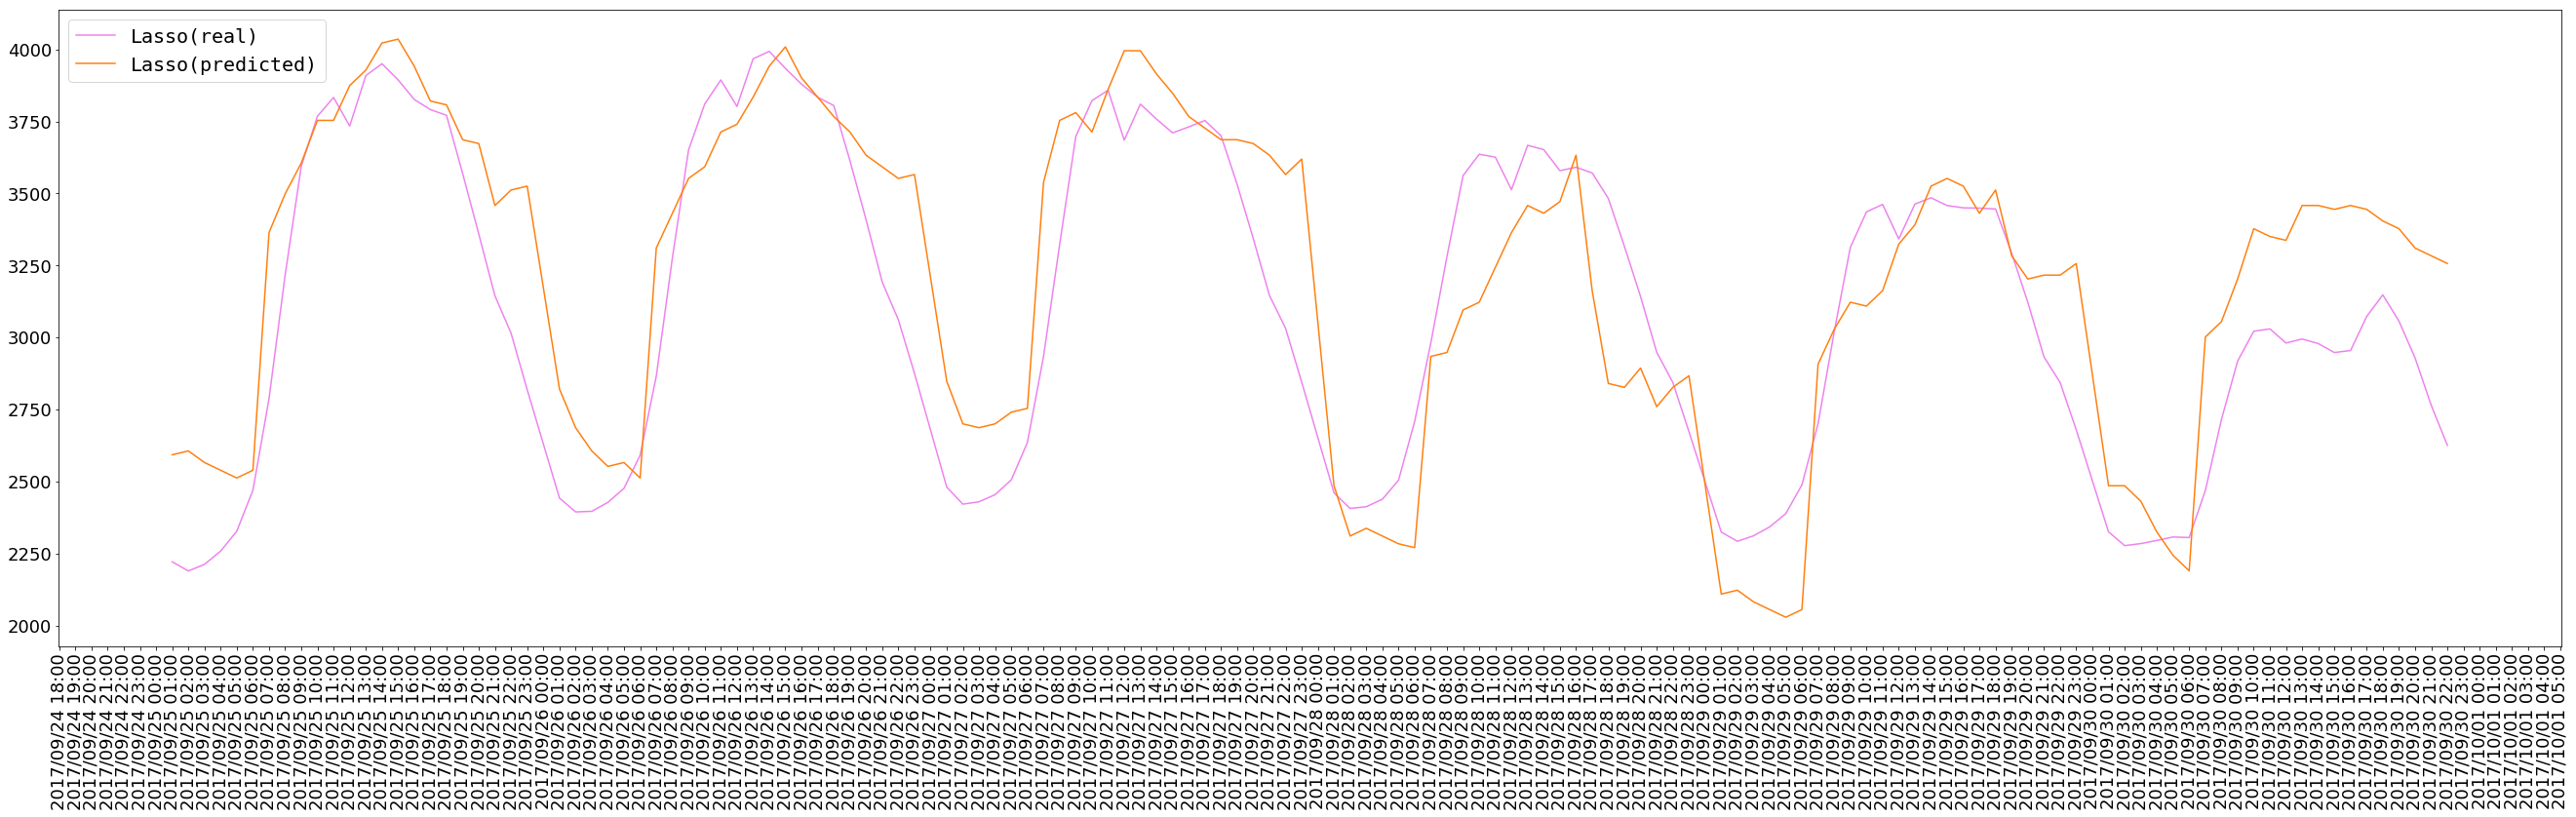

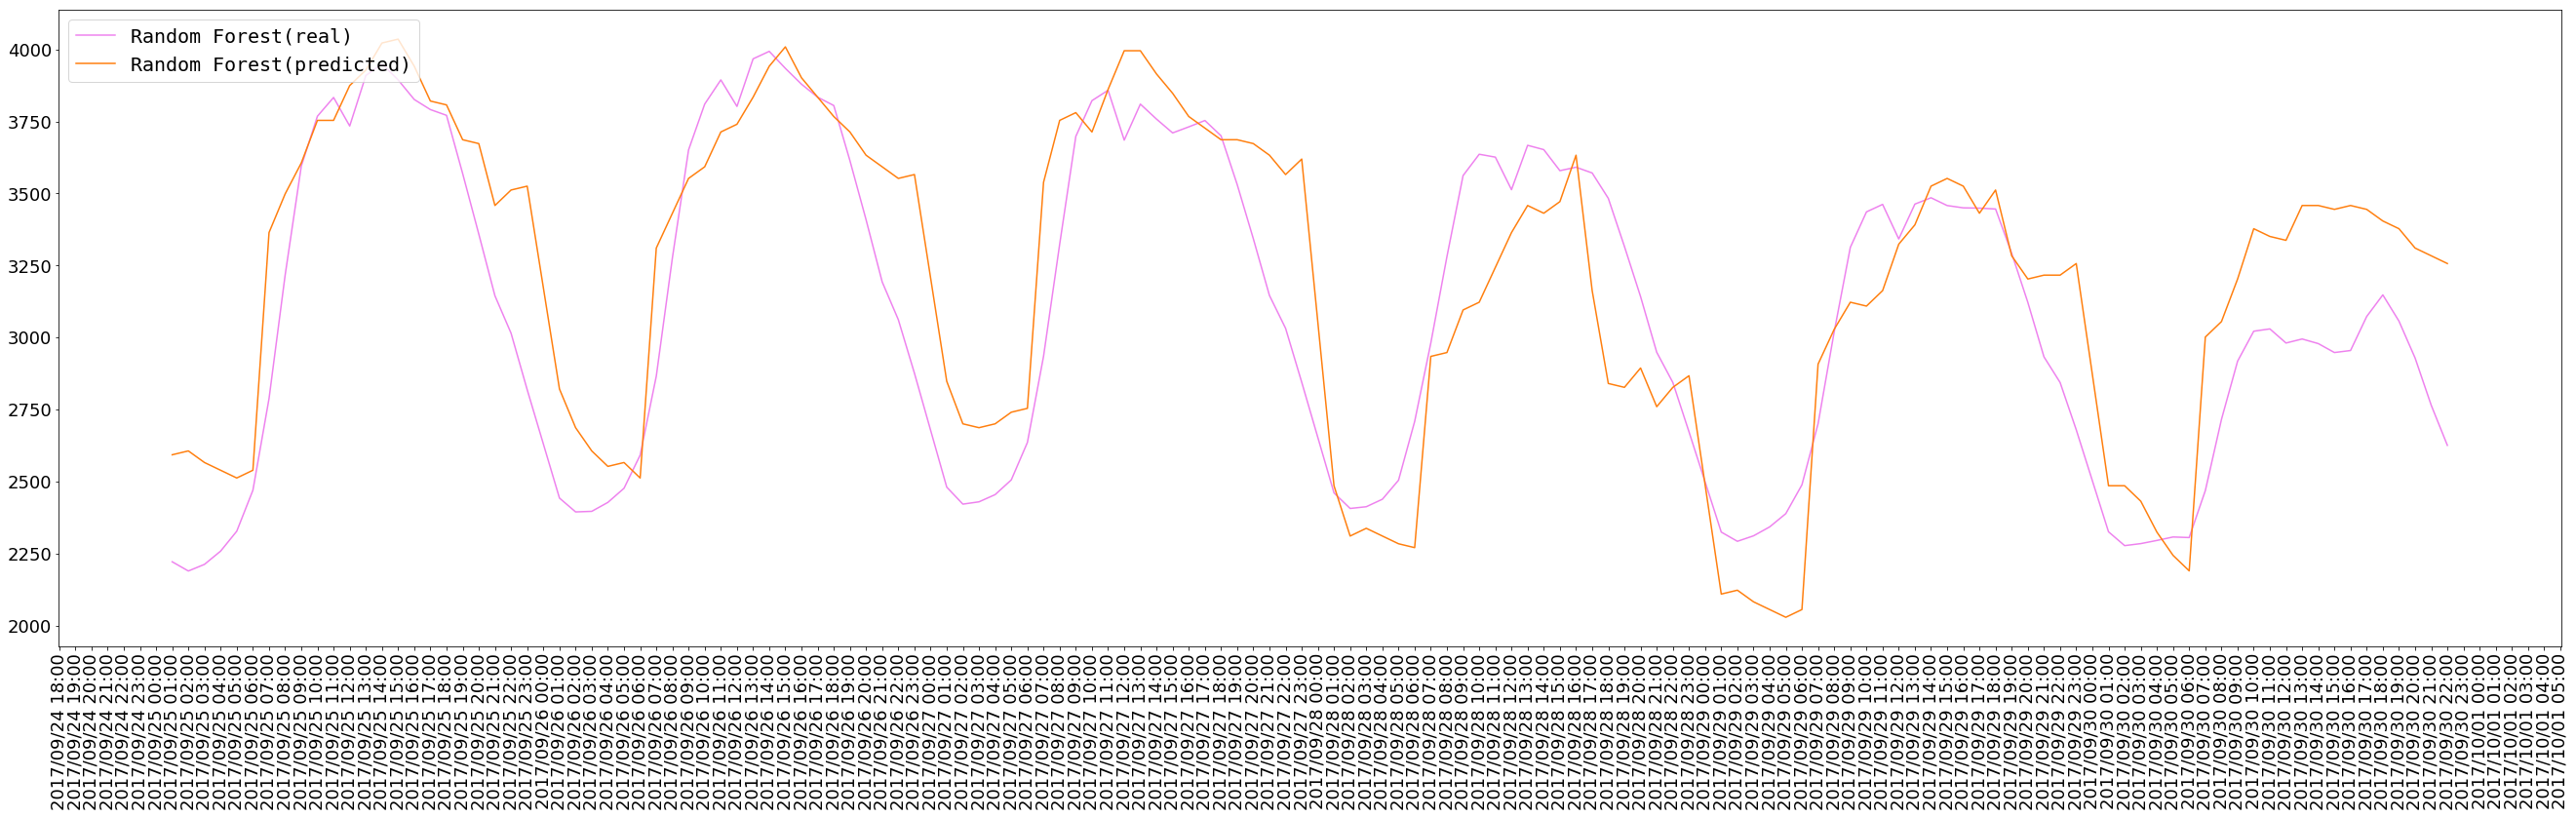

In [5]:
utilities.plot_predictions(time_test_df, y_test_df, predictions_lasso, "2017/09/25 01:00", "2017/09/30 23:00", "Lasso")
utilities.plot_predictions(time_test_df, y_test_df, predictions_lasso, "2017/09/25 01:00", "2017/09/30 23:00", "Random Forest")

So this is a simple example to show how to use timeseriesprocessing package.

For this example, as TOU calendar is widely used in electric power companies, trying to turn TOU as features should be consider as a good method of feature engineering.